# Feature Permutation 

Run the Breiman permutation test for feature importance calculation for UC3 data and models. 

In [1]:
import xarray as xr
import netCDF4
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import gc
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import box
from affine import Affine
import sys
import seaborn as sns
import rasterio
import os
from collections import defaultdict
import random
from methods.feature_permutation import FeaturePermutation
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_precision_recall_curve

In [2]:
import warnings
warnings.filterwarnings('ignore')

Upload UC3 data: 

In [3]:
df = pd.read_csv(r"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/greece_pixel_dataset.csv")

In [4]:
list(df.columns)

['Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
 'x',
 'y',
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc',
 'burned_areas',
 'time',
 'datetime']

In [5]:
features = [
 'Fpar_500m',
 'Lai_500m',
 'LST_Day_1km',
 'LST_Night_1km',
 '1 km 16 days NDVI',
 '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
 'era5_max_u10',
 'era5_max_v10',
 'era5_max_t2m',
 'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp'
]

coordinates = ['x', 'y']

static_features = [ 
 'dem_mean',
 'dem_std',
 'aspect_mean',
 'aspect_std',
 'slope_mean',
 'slope_std',
 'roads_density_2020',
 'population_density',
 'clc'
]

target = 'burned_areas'

Data cleaning and train-test splitting: 

In [6]:
nan_fillvalue = -9999
df = df.fillna(nan_fillvalue)
time_split = int(df.time.max()*0.85)
train_df=df[df['time']<time_split]
test_df=df[df['time']>=time_split]

Fit a Random Forest and plot results: 

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2050
         1.0       0.73      0.62      0.67       634

    accuracy                           0.86      2684
   macro avg       0.81      0.78      0.79      2684
weighted avg       0.85      0.86      0.85      2684



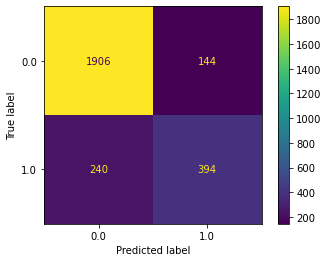

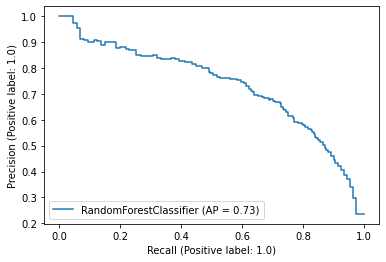

In [7]:
features_to_exclude = [
 'Fpar_500m',
 'Lai_500m',
#  'LST_Day_1km',
#  'LST_Night_1km',
#  '1 km 16 days NDVI',
#  '1 km 16 days EVI',
 'ET_500m',
 'LE_500m',
 'PET_500m',
 'PLE_500m',
#  'era5_max_u10',
#  'era5_max_v10',
#  'era5_max_t2m',
#  'era5_max_tp',
 'era5_min_u10',
 'era5_min_v10',
 'era5_min_t2m',
 'era5_min_tp',
#  'dem_mean',
 'dem_std',
#  'aspect_mean',
 'aspect_std',
#  'slope_mean',
#  'slope_std',
#  'roads_density_2020',
#  'population_density',
#  'clc'
]
features_filtered = [x for x in features + static_features if x not in features_to_exclude]

X_train, X_test = train_df[features_filtered], test_df[features_filtered]
y_train, y_test = train_df[target], test_df[target]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()
plot_precision_recall_curve(clf, X_test, y_test)  
plt.show()

Let us now fit the feature permutation method in order to see which are the most important features: 

In [8]:
config = {
    "model": clf,
    "X": np.array(X_train), 
    "y": y_train,
    "type": "predict_proba",
    "features":features_filtered,
    "Np": 10,
    "cost":"cross-entropy", 
    "path":"/Users/Michele/Desktop/ISP/projects/deepcube/uc3/data/permutation.png"
}

In [9]:
fp = FeaturePermutation(config)
fi = fp.fit()

Let us print the feature scores obtained through the permutation test:

In [10]:
print(fi["RESULT"])

[(4.487076726852838, 'LST_Day_1km'), (4.471644150004783, 'LST_Night_1km'), (3.523249036745247, 'era5_max_t2m'), (2.9672664556831365, 'era5_max_tp'), (2.701653978449232, 'era5_max_v10'), (2.4005752201088684, 'era5_max_u10'), (2.295387001174706, '1 km 16 days NDVI'), (2.1682306845841337, 'slope_mean'), (2.0418338508097515, 'dem_mean'), (2.0215674778235444, 'population_density'), (1.9387696939039176, 'slope_std'), (1.9079955226188456, '1 km 16 days EVI'), (1.8286855854731123, 'clc'), (1.729640076560915, 'roads_density_2020'), (1.392931283480884, 'aspect_mean')]


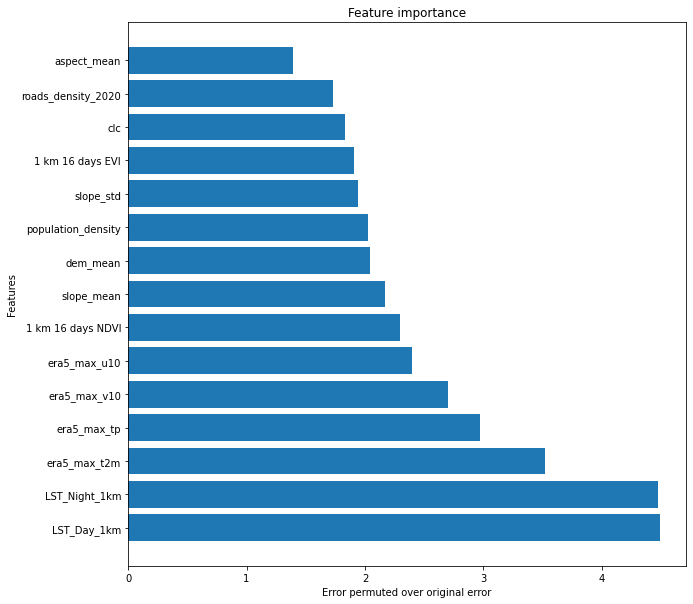

In [11]:
fp.plot(fi["RESULT"])

We can also call the run_all() method if we want to fit the permutation algorithm and show the results at the same time:

Feature  LST_Day_1km is ranked number  1  with a score of  4.50656434754656 +/- 0.030230964960451027
Feature  LST_Night_1km is ranked number  2  with a score of  4.332478713843412 +/- 0.02311780222038477
Feature  1 km 16 days NDVI is ranked number  7  with a score of  2.263163382561012 +/- 0.012355727515556933
Feature  1 km 16 days EVI is ranked number  12  with a score of  1.9678840975877683 +/- 0.007926785980245888
Feature  era5_max_u10 is ranked number  6  with a score of  2.475536657944745 +/- 0.009319330316461984
Feature  era5_max_v10 is ranked number  5  with a score of  2.53982819600071 +/- 0.010186612353617746
Feature  era5_max_t2m is ranked number  3  with a score of  3.668394989220997 +/- 0.02586418049969531
Feature  era5_max_tp is ranked number  4  with a score of  3.0336158235449195 +/- 0.027999680788198318
Feature  dem_mean is ranked number  9  with a score of  2.0428820752089236 +/- 0.010101812872379394
Feature  aspect_mean is ranked number  15  with a score of  1.3947664

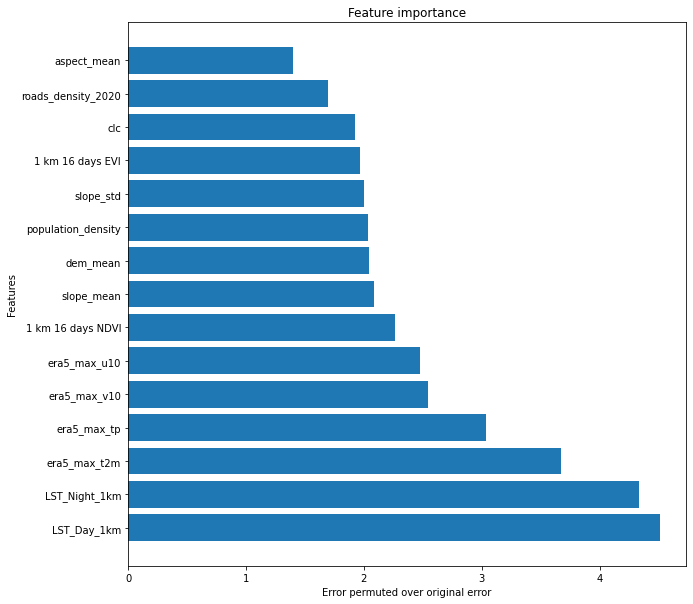

In [12]:
fp.run_all()

Mean decrease in impurity (built-in sklearn method for RF feature importance): 

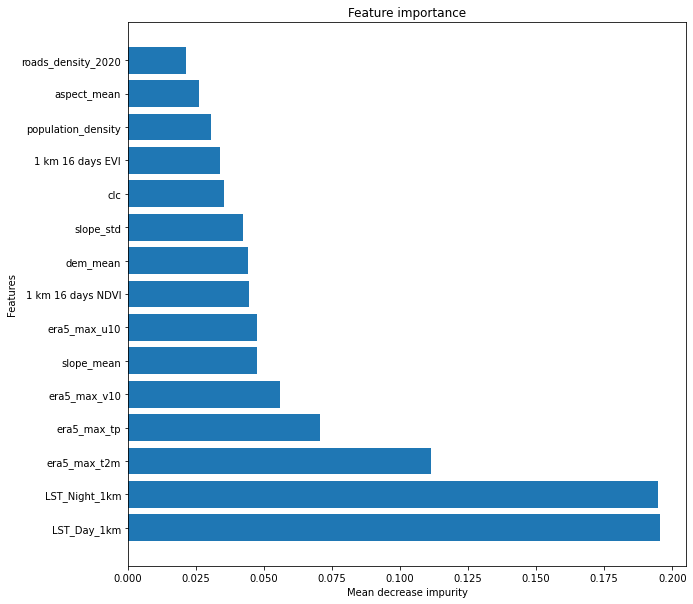

In [18]:
importances = clf.feature_importances_
fi_vector, ordered_features = list(zip(*sorted(zip(importances,features_filtered),reverse=True)))

plt.figure(figsize=(10,10))
plt.barh(ordered_features, fi_vector)
plt.title('Feature importance')
plt.ylabel('Features')
plt.xlabel('Mean decrease impurity')
plt.show()

Method performance: 

In [19]:
%timeit fp.fit()

34.4 s ± 2.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
